# Intro

In this example we use geometric surrogate graphs from `braingraphgeo` to demonstrate hub node visualizations that show geometric bias in tractography.

We start by importing some base packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from braingraphgeo.utils import load_connectivity_matrix
%matplotlib inline

The goal is to create a network diagram in physical coordinates showing connections between a fixed number of the strongest "hub" nodes in a given graph. Visual comparisons between empirical and geometric graphs will give us a clue into the role that geometry plays in determining network structure from each modality. 

# Load data 

First, let's load our data:

In [2]:
def load_mean_tract_graph(path):
    '''Utility function to load and average tractography graphs'''
    tract_mats = []
    for i in range(1,6):
        mat = load_connectivity_matrix(path + f'_n{i}.csv').values
        tract_mats.append(mat)
    tract = np.mean(tract_mats,0)
    return tract

tracer = load_connectivity_matrix('../data/tracer.csv').values
dense_tract = load_mean_tract_graph('../data/tract_dense')
endpoint_tract = load_mean_tract_graph('../data/tract_endpoint')

In order to visualize our networks in physical coordinates, we need the locations of the nodes. These were calculated as the center of mass of each node mask in the Allen CCF v3 reference space and are available in the data folder:

In [3]:
position_df = pd.read_csv('../data/node_positions.csv')
node_positions_array = position_df.loc[:,'x':'z'].values
position_df

,Allen ID,Hemisphere,x,y,z
0,184,ipsilateral,68.343685,108.254658,51.219462
1,985,ipsilateral,78.590315,88.033051,55.376458
2,993,ipsilateral,70.259474,94.935666,57.910758
3,353,ipsilateral,92.878307,74.274471,54.414683
4,329,ipsilateral,90.150127,63.610051,61.484733
...,...,...,...,...,...
567,1041,contralateral,20.016731,19.540606,25.712443
568,1049,contralateral,25.500000,25.689970,26.768997
569,989,contralateral,47.453815,13.767068,42.108434
570,91,contralateral,38.484634,15.725768,39.747045


# Network diagrams

the `vis_strongest_nodes` function from the `vis` module in `braingraphgeo` generates network diagrams with the following features:

1. Nodes are represented as spheres with color corresponding to their strength
2. "Hub nodes" are manually set with the `n_nodes` argument 
3. Hub node spheres have twice the radius of non-hub nodes
4. Connections between hub nodes are colored teal

The function uses the `fury` package which is a wrapper for `vtk`. The graphs won't render in Jupyter directly, so it saves three views to the `out_path`, which I can plot in Jupyter with a matplotlib utility function:

In [4]:
def plot_grid(path):
    fns = [path + f'{view}.png' for view in ['cor','sag','ax']]
    titles = ['Coronal','Sagittal','Axial']
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    for i in range(3):
        im = plt.imread(fns[i])
        ax[i].imshow(im)
        ax[i].set_aspect('equal')
        ax[i].set_title(titles[i],fontsize=12)
        ax[i].axis('off')

Let's look at the network diagram for the top 85 nodes of the tracer graph:

In [5]:
from braingraphgeo.vis import vis_strongest_nodes

n_nodes=85
out_path='imgs/tracer_empirical_'
vis_strongest_nodes(positions=node_positions_array, 
                    edges=tracer, 
                    out_path=out_path,
                    n_nodes=85)

### Tracer empirical

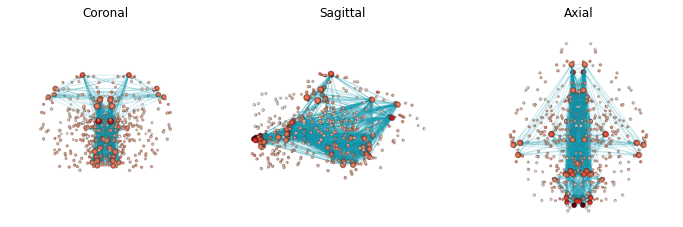

In [6]:
plot_grid(out_path)

Now let's use the tracer graph to construct a geometric surrogate and look at its hub structure:

In [7]:
from braingraphgeo.surrogates import geomsurr

distance = load_connectivity_matrix('../data/fiber_distances.csv').values
tracer_geo = geomsurr(tracer, distance)
out_path='imgs/tracer_geo_'
vis_strongest_nodes(positions=node_positions_array, 
                    edges=tracer_geo, 
                    out_path=out_path,
                    n_nodes=85)

### Tracer empirical

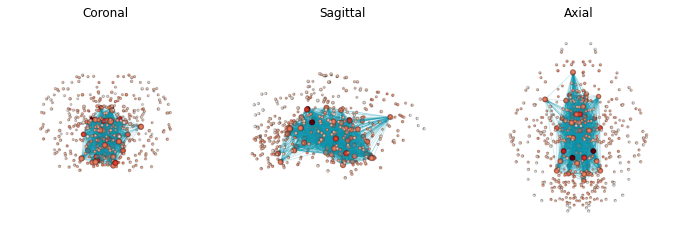

In [8]:
plot_grid(out_path)

Accordingly, we see that tracer networks place their hub nodes much further out into the periphery of the brain than would be predicted by geometric effects alone. 

Now let's look at the same comparison with the tractography networks:

In [9]:
# Dense tract empirical
dense_emp_out_path = 'imgs/dense_tract_empirical_'
vis_strongest_nodes(positions=node_positions_array, 
                    edges=dense_tract, 
                    out_path=dense_emp_out_path,
                    n_nodes=85)
# Dense tract geometric
dense_geo = geomsurr(dense_tract, distance)
dense_geo_out_path = 'imgs/dense_tract_geo_'
vis_strongest_nodes(positions=node_positions_array, 
                    edges=dense_geo, 
                    out_path=dense_geo_out_path,
                    n_nodes=85)
# Endpoint tract empirical
endpoint_emp_out_path = 'imgs/endpoint_tract_empirical_'
vis_strongest_nodes(positions=node_positions_array, 
                    edges=endpoint_tract, 
                    out_path=endpoint_emp_out_path,
                    n_nodes=85)
# Endpoint tract geometric
endpoint_geo = geomsurr(endpoint_tract, distance)
endpoint_geo_out_path = 'imgs/endpoint_tract_geo_'
vis_strongest_nodes(positions=node_positions_array, 
                    edges=endpoint_geo, 
                    out_path=endpoint_geo_out_path,
                    n_nodes=85)

### Dense tract empirical

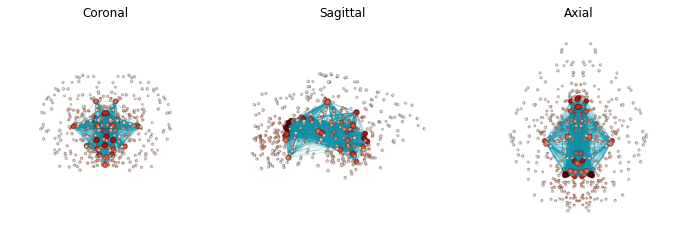

In [10]:
plot_grid(dense_emp_out_path)

### Dense tract geometric

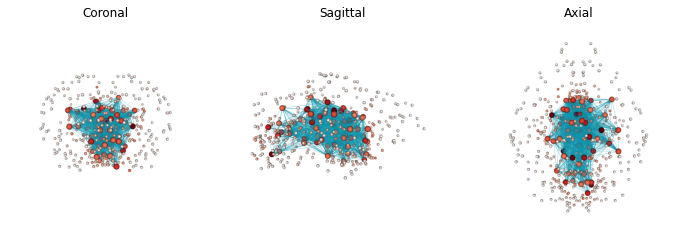

In [11]:
plot_grid(dense_geo_out_path)

### Endpoint tract empirical

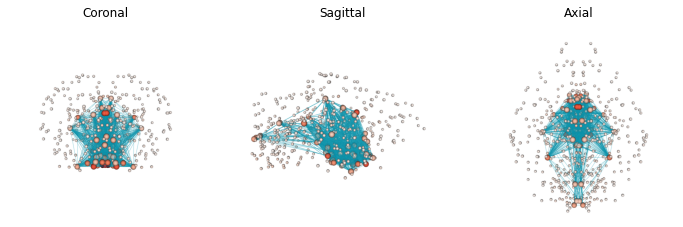

In [12]:
plot_grid(endpoint_emp_out_path)

### Endpoint tract geometric

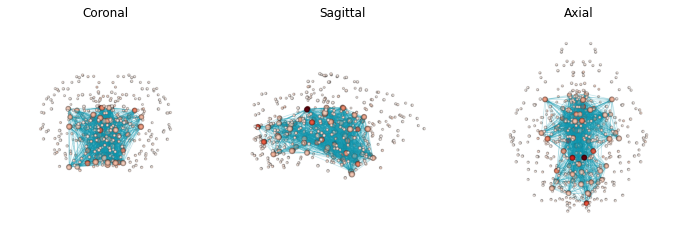

In [13]:
plot_grid(endpoint_geo_out_path)

# Results

With these diagrams, we see that

1. Both tractography methods put their hub nodes closer to the center of the brain than predicted by the tracer graph
2. Differences between empirical and geometric hub structures are MUCH smaller for tractography than tracers, indicating that geometry plays a larger role in determining the hub structure of tractography graphs than tracer graphs